In [1]:
from pymodelica import compile_fmu
import traceback
import logging

from pyfmi import load_fmu
import pymodelica

import os
import shutil
import sys
import matplotlib.pyplot as plt

In [14]:
debug_solver = True
model="TheveninBasedBattery"
generate_plot = True

In [36]:
# compile fmu
fmu_name = compile_fmu(model,
                       version="2.0",
                       compiler_log_level='warning', #'info', 'warning',
                       compiler_options = {"generate_html_diagnostics" : True,
                                           "nle_solver_tol_factor": 1e-2}) # 1e-2 is the default

In [46]:
# Load model
mod = load_fmu(fmu_name, log_level=4) # default setting is 3
mod.set_max_log_size(2073741824) # = 2*1024^3 (about 2GB)

In [47]:
# Retrieve and set solver options
x_nominal = mod.nominal_continuous_states
opts = mod.simulate_options() #Retrieve the default options

opts['solver'] = 'CVode' #'Radau5ODE' #CVode
opts['ncp'] = 500

if opts['solver'].lower() == 'cvode':
  # Set user-specified tolerance if it is smaller than the tolerance in the .mo file
  rtol = 1.0e-8
  x_nominal = mod.nominal_continuous_states

  if len(x_nominal) > 0:
    atol = rtol*x_nominal
  else:
    atol = rtol

  opts['CVode_options']['external_event_detection'] = False
  opts['CVode_options']['maxh'] = (mod.get_default_experiment_stop_time()-mod.get_default_experiment_start_time())/float(opts['ncp'])
  opts['CVode_options']['iter'] = 'Newton'
  opts['CVode_options']['discr'] = 'BDF'
  opts['CVode_options']['rtol'] = rtol
  opts['CVode_options']['atol'] = atol
  opts['CVode_options']['store_event_points'] = True # True is default, set to false if many events

  if debug_solver:
    opts['CVode_options']['clock_step'] = True


if debug_solver:
  opts["logging"] = True #<- Turn on solver debug logging
  mod.set("_log_level", 4)

In [48]:
res = mod.simulate(options=opts)

[CVode Warning] Internal t = 6973.98 and h = 2.1972e-13 are such that t + h = t on the next step. The solver will continue anyway.
[CVode Warning] Internal t = 6973.98 and h = 2.1972e-13 are such that t + h = t on the next step. The solver will continue anyway.
[CVode Warning] Internal t = 6973.98 and h = 2.82299e-13 are such that t + h = t on the next step. The solver will continue anyway.
[CVode Warning] Internal t = 6973.98 and h = 1.43113e-13 are such that t + h = t on the next step. The solver will continue anyway.
[CVode Warning] Internal t = 6973.98 and h = 7.31401e-14 are such that t + h = t on the next step. The solver will continue anyway.
[CVode Warning] Internal t = 6973.98 and h = 7.51614e-15 are such that t + h = t on the next step. The solver will continue anyway.
[CVode Warning] Internal t = 6973.98 and h = 7.51614e-15 are such that t + h = t on the next step. The solver will continue anyway.
[CVode Warning] Internal t = 6973.98 and h = 2.04617e-14 are such that t + h =

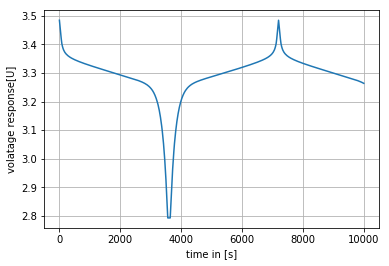

In [52]:
plt.plot(res['time'], res['voltageSource.U_ocv.v'])
plt.xlabel('time in [s]')
plt.ylabel('volatage response[U]')
plt.grid()
plt.show()